# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250407-09-49-00 - 09-49-00


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_6_locs.txt.
It is known that the shortest distance is 241.0


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 8 qubits needed for 6 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 8])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 8])


Set up model with gradient required:

In [11]:

model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 144 parameters in total, of which 144 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

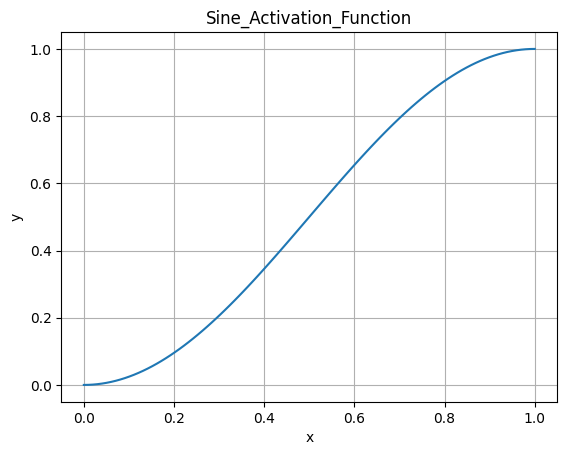

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 0.2094,  0.3052, -0.2862, -0.1573, -0.1064,  0.1403, -0.2006,  0.2137],
        [-0.1648, -0.0722, -0.0576,  0.3437,  0.1486, -0.2890, -0.0896,  0.0903],
        [ 0.1706,  0.0579,  0.1913, -0.0974,  0.2564, -0.3239,  0.1003,  0.1245],
        [-0.3331, -0.3215, -0.0525, -0.3437,  0.0051, -0.0980, -0.1544, -0.2904],
        [-0.3091,  0.1954,  0.1054, -0.0359,  0.1453,  0.1527,  0.2565, -0.2215],
        [ 0.0297, -0.1592,  0.1802, -0.0589,  0.3335,  0.1893,  0.0622,  0.2365],
        [-0.3259, -0.1357, -0.2941,  0.2986,  0.1378,  0.2913, -0.1235, -0.0812],
        [ 0.2816,  0.2920, -0.2334,  0.1968, -0.0480,  0.0140,  0.3175,  0.0034]],
       device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.1740, -0.2974, -0.0043, -0.1941, -0.1410,  0.3135,  0.0459, -0.3122],
       device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[-0.1941,  0.0218,  0.1012,  0.0513,  0.0073, -0.0813, -0

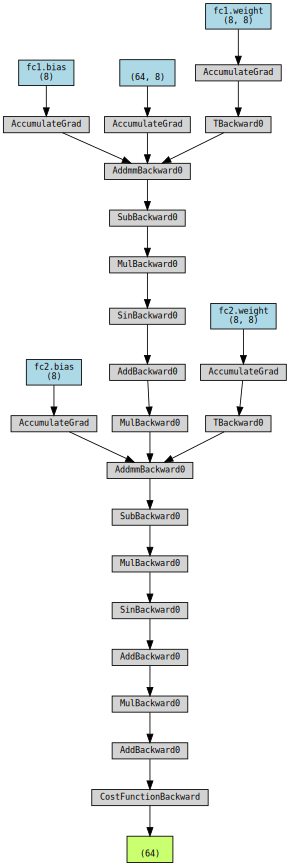

In [14]:
output = model(my_input)
#lowest_cost = float(output)
lowest_cost = output.min()
#print(f'Output = {output:.3f}')
#print(output)
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 348.295 Epoch min cost:241.000, Lowest Cost to date: 241.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 2131.47
Epoch 0, fc2.weight grad: 1489.01
Epoch 0, fc2.bias grad: 3768.88
Epoch 5, Average cost: 322.972 Epoch min cost:256.300, Lowest Cost to date: 241.000
Epoch 5, fc1.weight grad: 0.00
Epoch 5, fc1.bias grad: 211880.89
Epoch 5, fc2.weight grad: 10535.17
Epoch 5, fc2.bias grad: 6446.37
Epoch 10, Average cost: 332.473 Epoch min cost:256.300, Lowest Cost to date: 241.000
Epoch 10, fc1.weight grad: 0.00
Epoch 10, fc1.bias grad: 121954.01
Epoch 10, fc2.weight grad: 7318.63
Epoch 10, fc2.bias grad: 5068.42
Epoch 15, Average cost: 325.148 Epoch min cost:241.000, Lowest Cost to date: 241.000
Epoch 15, fc1.weight grad: 0.00
Epoch 15, fc1.bias grad: 152845.98
Epoch 15, fc2.weight grad: 4949.37
Epoch 15, fc2.bias grad: 2565.66
Epoch 20, Average cost: 325.997 Epoch min cost:256.300, Lowest Cost to date: 241.000
Epoch 20, fc1.weight grad: 0.00
Epoch 20, fc1.

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 241.000 at epoch 0.
The best known cost is 241.000


Plot loss ratio by epoch:

Graph for Run ID: 20250407-09-49-00-09-49-00 being saved to graphs\20250407-09-49-00\09-49-00.png


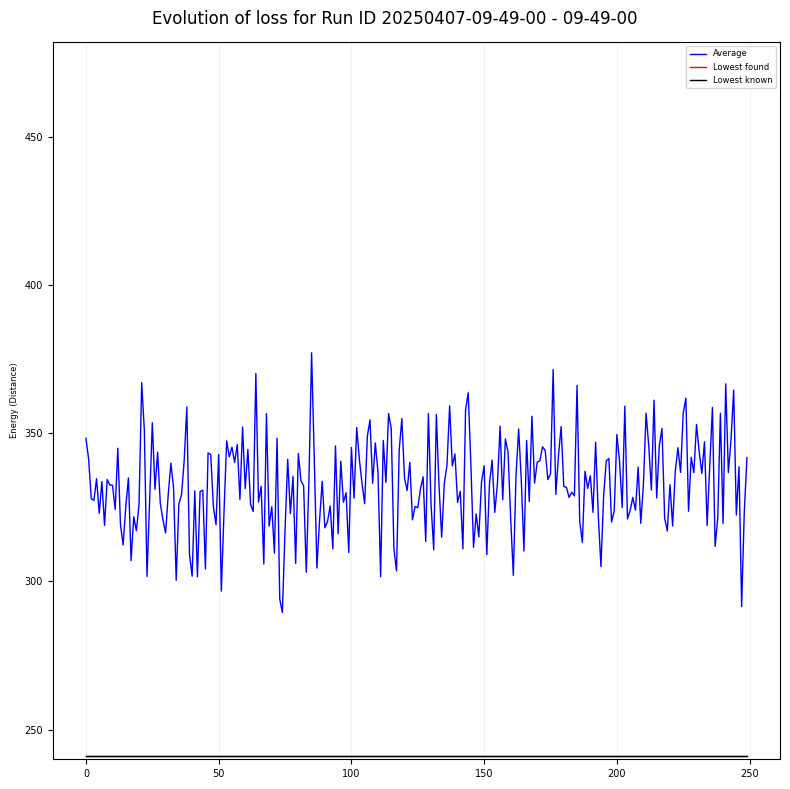

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 0.1992,  0.2903, -0.2722, -0.1496, -0.1012,  0.1334, -0.1908,  0.2033],
        [-0.1568, -0.0686, -0.0548,  0.3270,  0.1414, -0.2749, -0.0852,  0.0859],
        [ 0.1623,  0.0551,  0.1820, -0.0927,  0.2439, -0.3081,  0.0954,  0.1185],
        [-0.3168, -0.3059, -0.0500, -0.3269,  0.0048, -0.0932, -0.1469, -0.2763],
        [-0.2941,  0.1859,  0.1002, -0.0342,  0.1383,  0.1453,  0.2440, -0.2107],
        [ 0.0282, -0.1514,  0.1714, -0.0560,  0.3172,  0.1801,  0.0591,  0.2250],
        [-0.3100, -0.1291, -0.2797,  0.2840,  0.1310,  0.2771, -0.1175, -0.0772],
        [ 0.2678,  0.2778, -0.2220,  0.1872, -0.0456,  0.0133,  0.3020,  0.0032]],
       device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([128261.1250,  27946.3574,  97057.8984, -22729.4902,  42178.9609,
        -44371.4766, 199713.6094,  47879.0820], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[-8.8861e+01, -1.3056e+02, -1.1319e+02